# Post-Augmentation Modeling Notebook

## Importing Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from utils import *

%reload_ext autoreload
%autoreload 2


## Augmentation through ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_folder = '../split/train_imb'
val_folder = '../split/val'
test_folder = '../split/test2'

train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary',
                                                                       seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 1,
                                                                        class_mode = 'binary',
                                                                        shuffle=False)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
model = create_model((224, 224, 3))
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [82]:
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator)

## Augmentation through Albumentations

In [4]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


In [5]:
X_tr, y_tr = next(train_generator)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(test_generator)

## CNN Model

This model was inspired by the VGG16 model which was the only one that seemed to produce any normal metrics in my initial walkthrough of models.

In [ ]:
# build model similar to VGG16
def cnn_model_1(input_shape):
    return Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Flatten(),
        Dense(units=4096, activation='relu'),
        Dense(units=1, activation='sigmoid')
        ])

In [4]:
model2 = cnn_model_1((256, 256, 3))
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve = 'PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [5]:
filepath = '../models/cnn_model_1.h5'
earlyStopping = EarlyStopping(monitor = 'val_loss', verbose = 0, mode = 'min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')
history2 = model2.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save],
                     validation_data = val_generator)

Epoch 1/20
428/428 [==============================] - 4308s 10s/step - loss: 9.3389 - accuracy: 0.8453 - auc: 0.8187 - auc_1: 0.9056 - precision: 0.8978 - recall: 0.8975 - val_loss: 530.1702 - val_accuracy: 0.1282 - val_auc: 0.4651 - val_auc_1: 0.8342 - val_precision: 0.2105 - val_recall: 0.0031
Epoch 2/20
428/428 [==============================] - 3512s 8s/step - loss: 0.6581 - accuracy: 0.8798 - auc: 0.9037 - auc_1: 0.9642 - precision: 0.9022 - recall: 0.9470 - val_loss: 0.2545 - val_accuracy: 0.9110 - val_auc: 0.9015 - val_auc_1: 0.9798 - val_precision: 0.9232 - val_recall: 0.9785
Epoch 3/20
428/428 [==============================] - 3379s 8s/step - loss: 0.3595 - accuracy: 0.9104 - auc: 0.9329 - auc_1: 0.9717 - precision: 0.9208 - recall: 0.9654 - val_loss: 0.2651 - val_accuracy: 0.9236 - val_auc: 0.9141 - val_auc_1: 0.9812 - val_precision: 0.9267 - val_recall: 0.9900
Epoch 4/20
428/428 [==============================] - 3498s 8s/step - loss: 0.4316 - accuracy: 0.9131 - auc: 0.9281

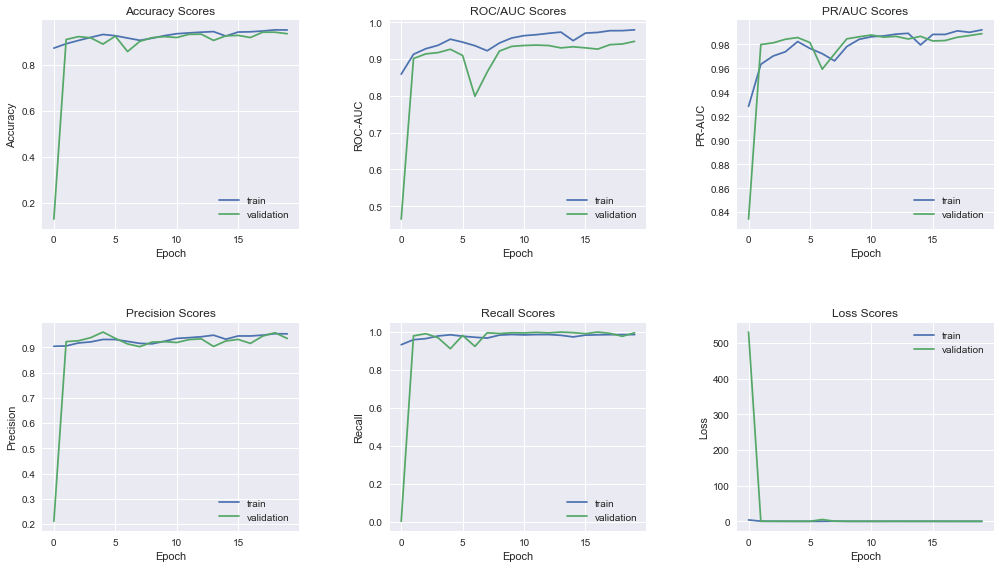

In [8]:
plt.style.use('seaborn')
sixplot(history2, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [31]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,auc,auc_1,precision,recall,val_loss,val_accuracy,val_auc,val_auc_1,val_precision,val_recall
0,4.088655,0.873538,0.858984,0.928289,0.904718,0.932002,530.170166,0.128154,0.465127,0.834200,0.210526,0.003072
1,0.585988,0.892544,0.913018,0.963356,0.905938,0.958317,0.254490,0.911023,0.901481,0.979847,0.923188,0.978495
2,0.395820,0.906871,0.928162,0.970257,0.917871,0.963888,0.265129,0.923639,0.914138,0.981249,0.926671,0.990015
3,0.282272,0.920322,0.937444,0.973830,0.922116,0.977910,0.226879,0.918327,0.917617,0.984241,0.938943,0.968510
4,0.192176,0.933041,0.954082,0.982336,0.931793,0.984057,0.270012,0.891102,0.926745,0.985684,0.961102,0.910906
5,0.221897,0.927485,0.946041,0.976601,0.931477,0.976565,0.235522,0.925631,0.909807,0.981466,0.936217,0.980799
6,0.320801,0.917398,0.936383,0.972220,0.924146,0.971187,5.254061,0.858566,0.798910,0.959308,0.914068,0.923195
7,0.823735,0.907456,0.922623,0.966210,0.916257,0.966769,0.453580,0.903054,0.864759,0.972119,0.903068,0.994624
8,0.245090,0.916667,0.943743,0.978159,0.914373,0.982520,0.235961,0.918991,0.921907,0.984599,0.921429,0.990783
9,0.190809,0.927778,0.957329,0.984174,0.924505,0.985594,0.200266,0.923639,0.934575,0.986305,0.923022,0.994624


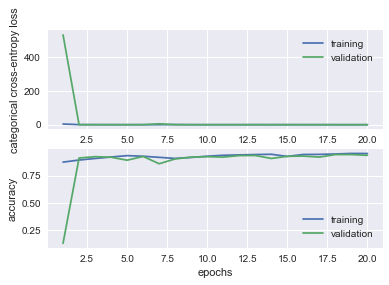

In [32]:
train_val_metrics(20, history2)

In [39]:
score = model2.evaluate(X_tt, y_tt, verbose = 1)
labels = model2.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

7/7 [==============================] - 24s 3s/step - loss: 2.2692 - accuracy: 0.4299 - auc: 0.5457 - auc_1: 0.7858 - precision: 0.7733 - recall: 0.3558
loss: 2.269223213195801
accuracy: 0.42990654706954956


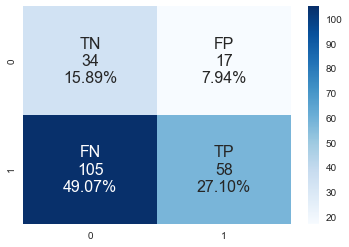

In [35]:
prob = model2.predict_generator(test_generator)
y_true = test_generator.classes
y_pred2 = prob > 0.5
make_confusion_matrix(y_true, y_pred2)

# CNN Model

In [6]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        class_mode = 'binary',
        batch_size = 753,
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


In [7]:
# 
def cnn2(input_shape):
    return Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Dropout(0.2),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Dropout(0.2), 
        MaxPool2D(pool_size=(3, 3)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dropout(0.25),     
        Dense(units=1, activation='sigmoid')
        ])

In [25]:
model3 = cnn2((256, 256, 3))
model3.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [29]:
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
mcp_save = ModelCheckpoint('../models/cnn2.h5', 
                           save_best_only = True, 
                           monitor = 'val_loss', 
                           mode = 'min')
tensorboard_cb = TensorBoard(log_dir="../logcnn2")
csv_logger = CSVLogger('../logcnn2/log.csv')
history3 = model3.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save, tensorboard_cb, csv_logger, lr_reduction],
                     validation_data = val_generator,
                     batch_size = 16)

Epoch 1/20
428/428 [==============================] - 2917s 7s/step - loss: 0.1703 - accuracy: 0.9418 - auc_2: 0.9611 - auc_3: 0.9828 - precision_1: 0.9434 - recall_1: 0.9825 - val_loss: 0.3061 - val_accuracy: 0.9349 - val_auc_2: 0.9304 - val_auc_3: 0.9850 - val_precision_1: 0.9413 - val_recall_1: 0.9862
Epoch 2/20
428/428 [==============================] - 2873s 7s/step - loss: 0.1534 - accuracy: 0.9484 - auc_2: 0.9685 - auc_3: 0.9858 - precision_1: 0.9493 - recall_1: 0.9848 - val_loss: 0.2337 - val_accuracy: 0.9402 - val_auc_2: 0.9145 - val_auc_3: 0.9768 - val_precision_1: 0.9417 - val_recall_1: 0.9923
Epoch 3/20
428/428 [==============================] - 2506s 6s/step - loss: 0.1498 - accuracy: 0.9501 - auc_2: 0.9720 - auc_3: 0.9876 - precision_1: 0.9516 - recall_1: 0.9846 - val_loss: 0.2227 - val_accuracy: 0.9482 - val_auc_2: 0.9370 - val_auc_3: 0.9863 - val_precision_1: 0.9513 - val_recall_1: 0.9908
Epoch 4/20
428/428 [==============================] - 1968s 5s/step - loss: 0.1387

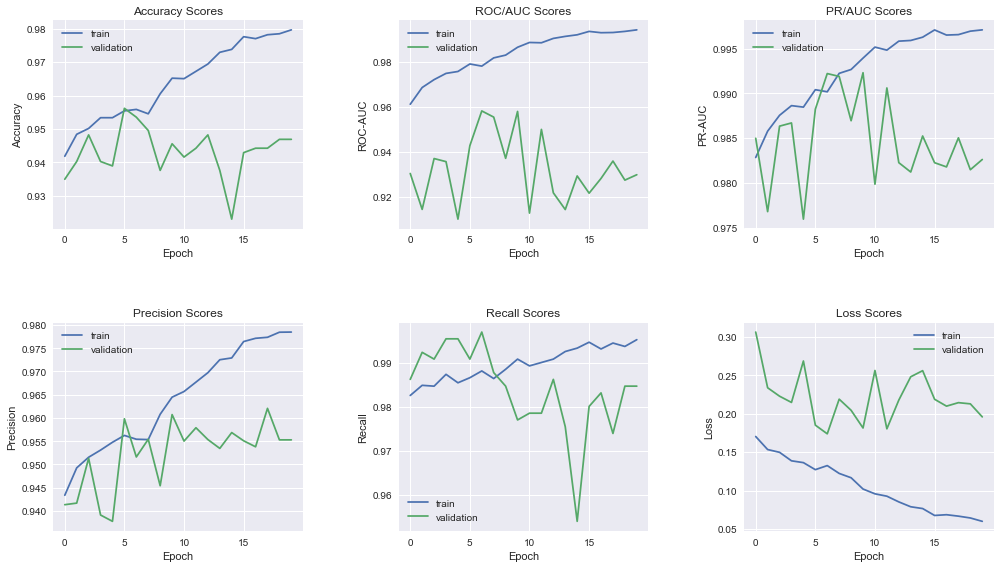

In [32]:
plt.style.use('seaborn')
sixplot(history3, 'auc_2', 'val_auc_2', 'auc_3', 'val_auc_3', 'precision_1', 'val_precision_1', 'recall_1', 'val_recall_1')

In [33]:
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,accuracy,auc_2,auc_3,precision_1,recall_1,val_loss,val_accuracy,val_auc_2,val_auc_3,val_precision_1,val_recall_1,lr
0,0.170320,0.941813,0.961078,0.982834,0.943379,0.982520,0.306095,0.934927,0.930379,0.984980,0.941349,0.986175,0.001000
1,0.153384,0.948392,0.968507,0.985777,0.949269,0.984825,0.233688,0.940239,0.914453,0.976776,0.941691,0.992320,0.001000
2,0.149778,0.950146,0.972001,0.987550,0.951550,0.984633,0.222725,0.948207,0.936997,0.986338,0.951327,0.990783,0.001000
3,0.138726,0.953363,0.974764,0.988632,0.953087,0.987322,0.214624,0.940239,0.935634,0.986696,0.939130,0.995392,0.001000
4,0.136372,0.953363,0.975616,0.988467,0.954774,0.985401,0.268470,0.938911,0.910131,0.975937,0.937771,0.995392,0.001000
5,0.127240,0.955409,0.978945,0.990414,0.956246,0.986554,0.185122,0.956175,0.942713,0.988231,0.959821,0.990783,0.001000
6,0.132522,0.955848,0.977992,0.990181,0.955423,0.988091,0.173825,0.953519,0.958119,0.992219,0.951613,0.996928,0.001000
7,0.122342,0.954532,0.981647,0.992244,0.955349,0.986362,0.218879,0.949535,0.955378,0.991900,0.955423,0.987711,0.001000
8,0.116714,0.960526,0.982873,0.992675,0.960792,0.988475,0.204404,0.937583,0.937103,0.986945,0.945428,0.984639,0.001000
9,0.102050,0.965205,0.986357,0.993949,0.964473,0.990780,0.181398,0.945551,0.957893,0.992315,0.960725,0.976959,0.000500


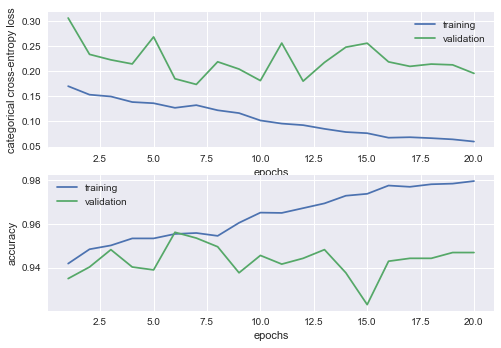

In [34]:
plt.style.use('seaborn')
train_val_metrics(20, history3)

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
mcp_save = ModelCheckpoint('../models/cnn2.h5', 
                           save_best_only = True, 
                           monitor = 'val_loss', 
                           mode = 'min')
tensorboard_cb = TensorBoard(log_dir="../logcnn2")
csv_logger = CSVLogger('../logcnn2/log.csv')
history3 = model3.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save, tensorboard_cb, csv_logger, lr_reduction],
                     validation_data = val_generator,
                     batch_size = 16)

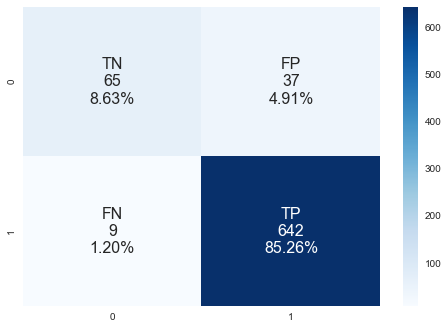

In [35]:
prob3 = model3.predict_generator(test_generator)
y_true = test_generator.classes
y_pred_3 = prob3 > 0.5
make_confusion_matrix(y_true, y_pred_3)

In [36]:
X_tt, y_tt = next(test_generator)

In [37]:
score = model3.evaluate(X_tt, y_tt, verbose = 1)
labels = model3.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1/1 [==============================] - 3s 3s/step - loss: 0.1543 - accuracy: 0.9062 - auc_2: 0.0000e+00 - auc_3: 0.0000e+00 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
loss: 0.1542806327342987
accuracy: 0.90625


In [38]:
y_score = model3.predict_proba(X_tt)
fpr, tpr, __ = roc_curve(y_tt, y_score)
roc_auc = auc(fpr, tpr)
prec,rec, __ = precision_recall_curve(y_tt, y_score)
pr_auc = auc(rec, prec)

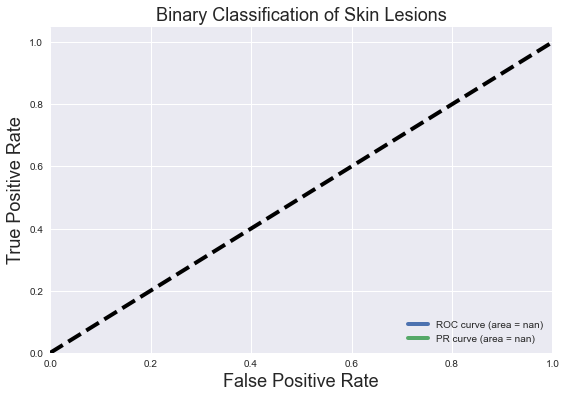

In [40]:
plt.figure(figsize = [9, 6])
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc, linewidth = 4)
plt.plot(rec, prec, label = 'PR curve (area = %0.2f)' % pr_auc, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Binary Classification of Skin Lesions', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()

In [8]:
model3b = cnn2((256, 256, 3))
model3b.load_weights("../models/CNN_v3.h5")
score = model3b.evaluate(X_tt, y_tt, verbose = 1)
labels = model3b.metrics_names

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.